## Bayesian optimization to infer Fractional Maxwell model fitting parameters for the oscillation data of polystyrene

First, we are importing a variety of essential libraries that will help us with numerical computations, data manipulation, plotting, machine learning, Bayesian optimization, and other specialized tasks.

### Libraries:
- **NumPy (`numpy`)**: A fundamental package for numerical operations in Python.
- **Pandas (`pandas`)**: A powerful data manipulation and analysis library.
- **Matplotlib (`matplotlib.pyplot`)**: A plotting library used for creating static, animated, and interactive visualizations.
- **SciPy Special Functions (`scipy.special`)**: Specifically importing the gamma function for mathematical computations.
- **PyTorch (`torch`)**: A deep learning library for tensor computations and building neural networks.
- **BoTorch and GPyTorch**: Libraries for Gaussian Process Regression:
  - `SingleTaskGP`: For constructing Gaussian Process models.
  - `Standardize`: For standardizing outcomes.
  - `ExactMarginalLogLikelihood`: For exact marginal log likelihood calculation.
  - `fit_gpytorch_mll`: For fitting GP models.
- **Sobol Sequence (`sobol_seq`)**: For generating Sobol sequences for quasi-random sampling.
- **BoTorch Acquisition and Optimization**:
  - `qExpectedImprovement`: For Monte Carlo-based expected improvement.
  - `optimize_acqf`: For optimizing the acquisition function.
- **Scikit-Learn Preprocessing (`sklearn.preprocessing`)**: A collection of scalers for feature scaling, including:
  - `MinMaxScaler`
  - `RobustScaler`
  - `StandardScaler`
  - `MaxAbsScaler`
- **pyRheo (`pyRheo.oscillation_evaluator`)**: A custom library for evaluating properties in oscillation.
- **SciencePlots (`scienceplots`)**: A library to enhance Matplotlib plots with scientific visual styles.

These imports will provide all the necessary tools for the subsequent analysis and model building steps in this notebook.


In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.optimize import minimize
import torch
import time as timer
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
import sobol_seq
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition.logei import qLogExpectedImprovement, qLogNoisyExpectedImprovement
from botorch.acquisition.analytic import LogExpectedImprovement, LogProbabilityOfImprovement
from botorch.optim.optimize import optimize_acqf
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, MaxAbsScaler
from gpytorch.kernels import RBFKernel, MaternKernel, ScaleKernel, LinearKernel, RQKernel
from gpytorch.constraints import Interval
from pyRheo.oscillation_evaluator import SAOSEvaluator
import scienceplots
plt.style.use(['science', 'nature', 'retro'])

## Random Error Generation, Objective Function, Sobol Sampling and Model Initialization

In this section, we define various key functions and setup procedures required for our model analysis and optimization:



In [2]:
##### Error function (optional noise injection, default off)
def createRandomError(n, std):
    return np.random.normal(loc=1, scale=std, size=n)


# Objective function to minimize (RRS weighted by true values)
# Multi-mode Maxwell objective function using fixed tau and fitted G_i
def objective_multimode_fixed_tau(params, omega, G_prime, G_double_prime, tau):
    """
    Objective function for multi-mode Maxwell model with fixed tau values.
    - params: array of length N_modes [logG1, logG2, ...]
    - omega: angular frequencies
    - G_prime, G_double_prime: experimental data
    - tau: predefined relaxation times (array length = N_modes)
    """
    N_modes = len(params)
    G = 10 ** params  # Ensure positivity

    # Compute model predictions
    G_model_prime = np.zeros_like(omega)
    G_model_double_prime = np.zeros_like(omega)

    for i in range(N_modes):
        wt = omega * tau[i]
        G_model_prime += G[i] * (wt**2) / (1 + wt**2)
        G_model_double_prime += G[i] * (wt) / (1 + wt**2)

    # Optionally add multiplicative noise (set std > 0 if needed)
    error_prime = createRandomError(len(omega), 0.0)
    error_double_prime = createRandomError(len(omega), 0.0)
    G_model_prime *= error_prime
    G_model_double_prime *= error_double_prime

    # Weighted residual sum of squares
    obj_gp = np.sum(((G_prime - G_model_prime) / G_prime) ** 2)
    obj_gpp = np.sum(((G_double_prime - G_model_double_prime) / G_double_prime) ** 2)
    obj_total = obj_gp + obj_gpp

    return -np.log10(obj_total)  # Minimization objective


# Function to create Sobol samples
def sobol_sample(space, n_samples):
    sobol_samples = sobol_seq.i4_sobol_generate(len(space), n_samples)
    sobol_scaled = sobol_samples * (space[:, 1] - space[:, 0]) + space[:, 0]
    return np.array(sobol_scaled)


# Initialize model function for single-objective problem
def initialize_model(train_x, train_obj):
    train_obj = train_obj.unsqueeze(-1)  # Add dimension for single task GP
    model = SingleTaskGP(
        train_x, train_obj,
        covar_module= ScaleKernel(
            MaternKernel(
                nu=1.5,
                #ard_num_dims=10,
                has_lengthscale=True,
                #lengthscale_constraint=Interval(0.001, 10),
                outcome_transform=None,
                train_Yvar=None
            )
        )
    )
    
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model


# Compute the qEI acquisition function to find new candidate points that maximize the objective
def compute_qei_acquisition_function(model, train_y, bounds, q_batch_size):
    acq_func = qLogExpectedImprovement(
        model=model,
        best_f=train_y.max(),  # since we're maximizing the negative of the objective error
        #maximize=True
    )
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=q_batch_size,
        num_restarts=1,
        raw_samples=500,
        options={"batch_limit": 5},
        sequential=True # Recommend to use True when the batch is higher than 5.
    )
    return candidates


## Loading Rheological Data and Defining Search Space

In this section, we load the rheological data from a CSV file and define the search space bounds for our parameter optimization.

In [3]:
# Load rheological data
import pandas as pd

data = pd.read_csv(
    #'./data/metal_coordinating_polymer_network/epstein.csv',
    './data/polystyrene/ps_saos_mc_data.csv',
    delimiter=',',
    decimal="."
)

# Extract columns
omega_raw = data['Angular Frequency'].values
G_prime_raw = data['Storage Modulus'].values
G_double_prime_raw = data['Loss Modulus'].values

# -------------------------------
# Downsample to be roughly uniform in log-frequency
# -------------------------------
n_bins = 100  # number of frequency bins
log_omega = np.log10(omega_raw)
bins = np.linspace(log_omega.min(), log_omega.max(), n_bins + 1)
bin_indices = np.digitize(log_omega, bins)

# Prepare lists for downsampled data
omega_ds = []
G_prime_ds = []
G_double_prime_ds = []

for i in range(1, n_bins + 1):
    mask = bin_indices == i
    if np.any(mask):
        omega_ds.append(np.mean(omega_raw[mask]))
        G_prime_ds.append(np.mean(G_prime_raw[mask]))
        G_double_prime_ds.append(np.mean(G_double_prime_raw[mask]))

# Overwrite original variables with downsampled data
omega = np.array(omega_ds)
G_prime = np.array(G_prime_ds)
G_double_prime = np.array(G_double_prime_ds)


def create_multimode_search_space(N_modes, omega, G_ref, margin=2.0):
    """
    Create parameter search space for N_modes.
    - omega: array of angular frequencies (rad/s)
    - G_ref: array of G values (use G' or a mixture) sampled at the omegas
    - margin: +/- in log10(G) around the center

    Returns:
        param_space: (N_modes, 2) array of [lower, upper] in log10(G)
        taus: (N_modes,) array of tau values (seconds), ordered largest -> smallest
        centers_logG: (N_modes,) center log10(G) used for each mode
    """
    omega = np.asarray(omega)
    G_ref = np.asarray(G_ref)

    if omega.ndim != 1 or G_ref.ndim != 1:
        raise ValueError("omega and G_ref must be 1-D arrays")
    if omega.size != G_ref.size:
        raise ValueError("omega and G_ref must have the same length")
    if np.any(G_ref <= 0):
        raise ValueError("G_ref must be strictly positive to take log10")

    # tau range: from largest tau (1/omega.min --> low freq) to smallest tau (1/omega.max --> high freq)
    log_tau_start = np.log10(1.0 / omega.min())   # largest tau (slowest)
    log_tau_end   = np.log10(1.0 / omega.max())   # smallest tau (fastest)

    # create taus ordered largest -> smallest
    log_taus = np.linspace(log_tau_start, log_tau_end, N_modes)
    taus = 10.0 ** log_taus

    param_space = []
    centers_logG = []

    for i, tau in enumerate(taus):
        omega_i = 1.0 / tau
        # find nearest measured omega (use log-space distance to be scale-invariant)
        idx = np.argmin(np.abs(np.log10(omega) - np.log10(omega_i)))
        center = np.log10(G_ref[idx])
        centers_logG.append(center)
        lower = center - margin
        upper = center + margin
        param_space.append([lower, upper])

        print(f"Mode {i+1:2d}: tau = {tau:.3e} s  (omega ≈ {omega_i:.3e} rad/s)  "
              f"index={idx}, center log10(G) = {center:.3f}, bounds = [{lower:.3f}, {upper:.3f}]")

    return np.array(param_space), taus, np.array(centers_logG)


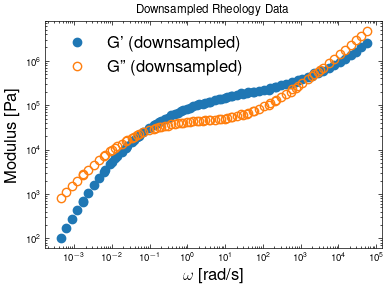

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))

# Plot Storage and Loss modulus
plt.plot(omega, G_prime, 'o', markersize=6, color='#1f77b4', label="G' (downsampled)")
plt.plot(omega, G_double_prime, 'o', markersize=6, color='#ff7f0e', fillstyle="none", label="G'' (downsampled)")

# Log-log axes
plt.xscale('log')
plt.yscale('log')

# Labels and legend
plt.xlabel('$\\omega$ [rad/s]', fontsize=12)
plt.ylabel('Modulus [Pa]', fontsize=12)
plt.legend(fontsize=12)

plt.title("Downsampled Rheology Data")
plt.tight_layout()
plt.show()


## Initial Sampling, Scaling, and Model Initialization

In this section, we conduct the initial exploration phase of our optimization process.


## Acquisition and Model Updating

In this section, we perform the exploitation phase of our optimization process. We iteratively generate new samples using the q-Expected Improvement (qEI) acquisition function, evaluate the objective function at these new sample points, and update our model accordingly.

### Iterative Optimization Process

For each iteration in the exploitation phase:
1. **Generate New Candidates**: We compute new candidate points using the qEI acquisition function.
2. **Evaluate Objective**: The objective function is evaluated at the new candidate points.
3. **Apply Scaling**: The new objective values are scaled using the previously defined MaxAbsScaler.
4. **Update Samples and Objectives**: The new sample and corresponding objective values (both original and scaled) are appended to the existing lists of samples and objective values. We also save the index of the new sample for tracking purposes.
5. **Update Tensors**: The updated samples and objective values are converted to tensors.
6. **Model Update**: The GP model is re-initialized and fitted using the updated data.
7. **Logging**: The iteration details, including the new sample and objective value, are printed.


In [5]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available?:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current GPU:", torch.cuda.get_device_name(0))


PyTorch version: 2.1.0
CUDA available?: True
Number of GPUs: 1
Current GPU: NVIDIA RTX A2000 12GB


In [6]:
import warnings
import time as timer
import torch
import numpy as np
from botorch.models.utils.assorted import InputDataWarning

warnings.filterwarnings("ignore", category=InputDataWarning)
device_choice = 'cpu'
device = torch.device(device_choice)
print("Using device:", device)

# --- Set number of modes and generate fixed tau ---
N_modes = 10 # Example: 20 Maxwell modes

def generate_tau(omega, N_modes):
    tau_min = 1 / max(omega)  # high-frequency limit
    tau_max = 1 / min(omega)  # low-frequency limit
    return np.logspace(np.log10(tau_min), np.log10(tau_max), N_modes)

tau_fixed = generate_tau(omega, N_modes)

# --- Create search space (logG only) ---
param_space, taus, centers = create_multimode_search_space(N_modes, omega, G_prime, margin=2.0)
print(param_space)
print(taus)
print(centers)



# --- Objective wrapper for Bayesian Optimization ---
def objective_bo_wrapper(x):
    return objective_multimode_fixed_tau(x, omega, G_prime, G_double_prime, taus)

# --- BO Loop Parameters ---
results = []
best_model = None
best_objective_value_overall = float('-inf')
best_X_samples = None
best_y_samples = None
max_y_per_iteration = []

n_runs = 1
n_initial_points = 8
n_exploitation_iter = 500
no_improvement_limit = 20
tolerance = 1e-2
q_batch_size = 2

# --- BO Loop ---
for run in range(n_runs):
    print(f"\nRun {run + 1}/{n_runs}")

    # Initial Sobol sampling
    X_samples = sobol_sample(param_space, n_initial_points)
    y_samples = np.array([objective_bo_wrapper(x) for x in X_samples])

    X_samples_tensor = torch.tensor(X_samples, dtype=torch.double, device=device)
    y_samples_tensor = torch.tensor(y_samples, dtype=torch.double, device=device)

    bounds = torch.stack([
        torch.tensor(param_space[:, 0], dtype=torch.double, device=device),
        torch.tensor(param_space[:, 1], dtype=torch.double, device=device)
    ])

    print("Initial X_samples shape:", X_samples.shape)
    print("Initial y_samples shape:", y_samples.shape)

    # Initialize and train GP
    mll, model = initialize_model(X_samples_tensor, y_samples_tensor)
    model = model.to(device)
    fit_gpytorch_mll(mll)

    # Exploitation loop
    objective_values = list(y_samples)
    times_per_iteration = []
    cumulative_time = 0
    best_objective_value_run = float('-inf')       # used for tolerance logic
    true_best_objective_value_run = float('-inf')  # always updated
    no_improvement_counter = 0

    for i in range(n_exploitation_iter):
        torch.manual_seed(42 + i)
        np.random.seed(42 + i)

        new_candidates = compute_qei_acquisition_function(
            model, y_samples_tensor, bounds, q_batch_size=q_batch_size
        )
        new_batch = new_candidates.detach().cpu().numpy()
        new_batch_y = [objective_bo_wrapper(x) for x in new_batch]

        X_samples = np.vstack([X_samples, new_batch])
        y_samples = np.append(y_samples, new_batch_y)
        X_samples_tensor = torch.tensor(X_samples, dtype=torch.double, device=device)
        y_samples_tensor = torch.tensor(y_samples, dtype=torch.double, device=device)
        objective_values.extend(new_batch_y)
        max_y_per_iteration.append(y_samples_tensor.max().cpu().numpy())

        start_time = timer.time()
        mll, model = initialize_model(X_samples_tensor, y_samples_tensor)
        model = model.to(device)
        fit_gpytorch_mll(mll)
        if device.type == 'cuda':
            torch.cuda.synchronize()
        iteration_time = timer.time() - start_time
        times_per_iteration.append(iteration_time)
        cumulative_time += iteration_time

        print(f"Exploitation {i + 1}/{n_exploitation_iter} - Batch values: {new_batch_y}")

        batch_best = max(new_batch_y)

        # Always track the true best (for reporting at the end)
        if batch_best > true_best_objective_value_run:
            true_best_objective_value_run = batch_best

        # Keep tolerance-based logic for early stopping
        improvement = batch_best - best_objective_value_run
        if improvement > tolerance:
            best_objective_value_run = batch_best
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        if no_improvement_counter >= no_improvement_limit:
            print(f"Stopping early due to no significant improvement in the last {no_improvement_limit} iterations.")
            break

    if best_objective_value_run > best_objective_value_overall:
        best_objective_value_overall = best_objective_value_run
        best_model = model
        best_X_samples = X_samples
        best_y_samples = y_samples

    results.append({
        'objective_values': objective_values,
        'times_per_iteration': times_per_iteration,
        'cumulative_time': cumulative_time,
        'best_objective_value_run': true_best_objective_value_run  # ✅ use the true best
    })


# --- Print summary ---
for idx, res in enumerate(results):
    print(f"\nResults from Run {idx + 1}:")
    print("Objective values:", res['objective_values'])
    print("Best objective value in this run:", res['best_objective_value_run'])
    print("Total cumulative time:", res['cumulative_time'])

print("\nOverall best objective value:", best_objective_value_overall)
if best_model:
    print("Best X_samples from the best run:", best_X_samples)
    print("Best y_samples from the best run:", best_y_samples)
else:
    print("No best model found")

max_y_per_iteration = np.array(max_y_per_iteration)


Using device: cpu
Mode  1: tau = 2.268e+03 s  (omega ≈ 4.410e-04 rad/s)  index=0, center log10(G) = 2.018, bounds = [0.018, 4.018]
Mode  2: tau = 2.848e+02 s  (omega ≈ 3.512e-03 rad/s)  index=7, center log10(G) = 3.195, bounds = [1.195, 5.195]
Mode  3: tau = 3.576e+01 s  (omega ≈ 2.796e-02 rad/s)  index=17, center log10(G) = 4.091, bounds = [2.091, 6.091]
Mode  4: tau = 4.491e+00 s  (omega ≈ 2.227e-01 rad/s)  index=27, center log10(G) = 4.642, bounds = [2.642, 6.642]
Mode  5: tau = 5.639e-01 s  (omega ≈ 1.773e+00 rad/s)  index=38, center log10(G) = 5.004, bounds = [3.004, 7.004]
Mode  6: tau = 7.082e-02 s  (omega ≈ 1.412e+01 rad/s)  index=49, center log10(G) = 5.196, bounds = [3.196, 7.196]
Mode  7: tau = 8.893e-03 s  (omega ≈ 1.124e+02 rad/s)  index=59, center log10(G) = 5.351, bounds = [3.351, 7.351]
Mode  8: tau = 1.117e-03 s  (omega ≈ 8.954e+02 rad/s)  index=69, center log10(G) = 5.571, bounds = [3.571, 7.571]
Mode  9: tau = 1.402e-04 s  (omega ≈ 7.131e+03 rad/s)  index=78, center 

## Visualizing Optimization Progress

In this section, we plot the negative of the objective function values as a function of the number of iterations. This helps us visually assess the optimization progress and the performance of the Sobol and Expected Improvement (EI) sampling strategies.

### Steps Involved in the Plotting Process:

1. **Configure the Plot**:
   We set the figure size and layout for constrained layout setting for better spacing.
   
2. **Prepare Data for Plotting**:
   - We create an array representing the iterations.
   - We negate the objective function values (`neg_objective_values`) because we are minimizing the objective, and lower values represent better performance.

3. **Plot the Sobol and EI Samples**:
   - Plot the initial Sobol samples in one color (`#89BFA9`), marking them as 'Sobol'.
   - Plot the subsequent EI samples in another color (`#60568A`), marking them as 'EI'.

4. **Customize Plot Appearance**:
   - Set the limits for the x-axis.
   - Label the x-axis as the number of iterations (`$n$`).
   - Label the y-axis as the log of the Residual Sum of Squares (RSS) weighted by true values (`$\\log$ RSS$_{w_{i}}$`).
   - Customize the font size of axis labels and tick labels.
   - Add a legend to distinguish between Sobol and EI samples.
  
5. **Display the Plot**:
   - Show the plot using `plt.show()`.
   
6. **Print the Minimum Objective Value**:
   - Print the minimum value of the negated objective values to see the best objective value achieved during the optimization process.


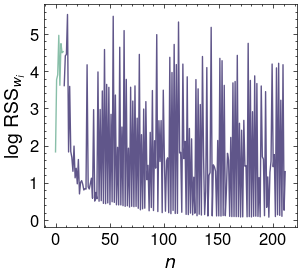

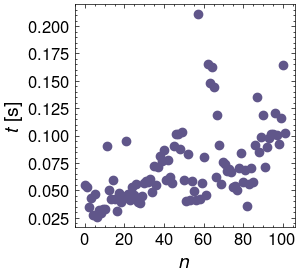

Run 1: The minimum value of the objective function in log10 scale is 0.0753
Run 1: Cumulative time for all iterations: 7.2866 seconds


In [7]:
# Prepare the figure for Objective Values
plt.figure(figsize=(3.0, 2.75), constrained_layout=True)

# Iterate over results from each run and plot
for idx, res in enumerate(results):
    objective_values = res['objective_values']
    iterations = np.arange(len(objective_values))
    neg_objective_values = -np.array(objective_values)

    # Plot initial Sobol samples
    plt.plot(
        iterations[:n_initial_points],
        neg_objective_values[:n_initial_points],
        '-', 
        markersize=6, 
        label=f'Run {idx+1} Sobol',
        color='#89BFA9'
    )

    # Plot EI samples
    plt.plot(
        iterations[n_initial_points:], 
        neg_objective_values[n_initial_points:], 
        '-', 
        markersize=6,
        label=f'Run {idx+1} logEI',
        color='#60568A'
    )

# Customize Plot Appearance
plt.xlabel('$n$', fontsize=14)                            # X-axis label
plt.ylabel('$\\log$ RSS$_{w_{i}}$', fontsize=14)           # Y-axis label
plt.xticks(fontsize=12)                                   # X-axis tick label size
plt.yticks(fontsize=12)                                   # Y-axis tick label size
#plt.legend(fontsize=10, loc="best")                       # Display legend

# Display or Save the Plot
plt.savefig("combined_fig_ei_oscillation_chia.pdf")
plt.show()

# Prepare the figure for Time per Iteration
plt.figure(figsize=(3.0, 2.75), constrained_layout=True)

# Iterate over results from each run and plot time per iteration
for idx, res in enumerate(results):
    times_per_iteration = res['times_per_iteration']
    iterations = np.arange(len(times_per_iteration))

    plt.plot(
        iterations[:len(times_per_iteration)], 
        times_per_iteration, 
        'o', 
        markersize=6, 
        label=f'Run {idx+1} Time', 
        color='#60568A'
    )

# Customize Plot Appearance
plt.xlabel('$n$', fontsize=14)                            # X-axis label
plt.ylabel('$t$ [s]', fontsize=14)                        # Y-axis label
plt.xticks(fontsize=12)                                   # X-axis tick label size
plt.yticks(fontsize=12)                                   # Y-axis tick label size
#plt.legend(fontsize=10, loc="best")                       # Display legend

# Display or Save the Time Plot
plt.savefig("combined_fig_time_per_iteration.pdf")
plt.show()

# Print Minimum Objective Values and Cumulative Time for Each Run
for idx, res in enumerate(results):
    neg_objective_values = -np.array(res['objective_values'])
    cumulative_time = res['cumulative_time']
    print(f"Run {idx + 1}: The minimum value of the objective function in log10 scale is {np.min(neg_objective_values):.4f}")
    print(f"Run {idx + 1}: Cumulative time for all iterations: {cumulative_time:.4f} seconds")


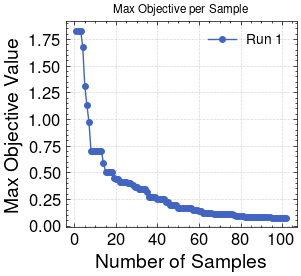

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------
# Plot Max Objective per Sample (from results)
# ------------------------------
plt.figure(figsize=(3.0, 2.75), constrained_layout=True)

for idx, res in enumerate(results):
    max_y = max_y_per_iteration  # NumPy array with max y per sample
    num_samples = np.arange(1, len(max_y) + 1)  # x-axis = total samples evaluated
    
    plt.plot(
        num_samples,
        -max_y,  # Negate if your objective is minimization
        '-o',
        markersize=4,
        label=f'Run {idx+1}',
        color=f'C{idx}'  # automatic color cycle
    )

# Customize plot
plt.xlabel('Number of Samples', fontsize=14)
plt.ylabel('Max Objective Value', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=10, loc="best")
plt.title('Max Objective per Sample')
plt.grid(True, linestyle='--', alpha=0.5)

# Save and show
plt.savefig("max_objective_per_sample.pdf")
plt.show()

## Fitting and Visualizing the Model with Best Parameters from Bayesian Optimization

In this section, we:
1. Define the fractional model evaluator.
2. Extract and print the best parameters obtained from the Bayesian Optimization (BO) phase.
3. Fit the model using the best parameters and compute the model values.
4. Calculate the Residual Sum of Squares (RSS) for the fitted model.
5. Plot the original data, the fitted model from Bayesian Optimization, and the optimized model.


Best parameters from Bayesian Optimization:
Mode 1: G = 121.985481, eta = 276622.433504, tau = 2267.666870
Mode 2: G = 2685.786959, eta = 764827.163823, tau = 284.768366
Mode 3: G = 20287.620311, eta = 725496.529984, tau = 35.760553
Mode 4: G = 43750.969243, eta = 196473.688246, tau = 4.490728
Mode 5: G = 58605.673428, eta = 33049.802452, tau = 0.563935
Mode 6: G = 65456.867734, eta = 4635.503514, tau = 0.070818
Mode 7: G = 74609.643100, eta = 663.512556, tau = 0.008893
Mode 8: G = 205285.406677, eta = 229.258132, tau = 0.001117
Mode 9: G = 425641.017670, eta = 59.692894, tau = 0.000140
Mode 10: G = 6100365.714618, eta = 107.435428, tau = 0.000018
Weighted RSS for the Bayesian Optimization model: 1.1893457864


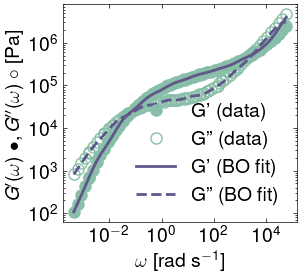

In [9]:
import matplotlib.pyplot as plt
from cycler import cycler  # for customizing plot cycles

# Extract the best parameters from Bayesian Optimization
best_idx = np.argmax(best_y_samples)
best_params = best_X_samples[best_idx]
N_modes = len(best_params)

# Only G_i were fitted
G_best = 10 ** best_params      # Fitted mode strengths
tau_best = taus            # Fixed relaxation times
eta_best = G_best * tau_best   # Compute viscosities

print("Best parameters from Bayesian Optimization:")
for i in range(N_modes):
    print(f"Mode {i+1}: G = {G_best[i]:.6f}, eta = {eta_best[i]:.6f}, tau = {tau_best[i]:.6f}")

# Compute multi-mode Maxwell predictions
G_model_prime = np.zeros_like(omega)
G_model_double_prime = np.zeros_like(omega)
for i in range(N_modes):
    wt = omega * tau_best[i]
    G_model_prime += G_best[i] * (wt**2) / (1 + wt**2)
    G_model_double_prime += G_best[i] * (wt) / (1 + wt**2)

# Compute the weighted RSS
rss_bo = np.sum(((G_prime - G_model_prime) / G_prime)**2) + \
         np.sum(((G_double_prime - G_model_double_prime) / G_double_prime)**2)
print(f"Weighted RSS for the Bayesian Optimization model: {rss_bo:.10f}")

# Plot the data and fitted multi-mode model
plt.figure(figsize=(3.0, 2.75), constrained_layout=True)
plt.plot(omega, G_prime, 'o', markersize=8, color='#89BFA9', label="G' (data)")
plt.plot(omega, G_double_prime, 'o', color='#89BFA9', fillstyle="none", markersize=8, label="G'' (data)")
plt.plot(omega, G_model_prime, '-', color='#60568A', lw=2, label="G' (BO fit)")
plt.plot(omega, G_model_double_prime, '--', color='#60568A', lw=2, label="G'' (BO fit)")

# Configure axes
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\omega$ [rad s$^{-1}$]', fontsize=14)
plt.ylabel(r'$G^{\prime}(\omega)~\bullet, G^{\prime \prime}(\omega)~\circ$ [Pa]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

# Save and show
plt.savefig("fig_bo_fit_multimode_maxwell.pdf")
plt.show()


In [10]:
# Objective function to minimize (RRS weighted by true values) for multi-mode Maxwell
def objective_minimize_multimode_fixed_tau(params, omega, G_prime, G_double_prime, taus):
    """
    params: array of length N_modes [logG1, logG2, ...]
    omega: angular frequencies
    G_prime: experimental storage modulus
    G_double_prime: experimental loss modulus
    taus: fixed relaxation times for each mode
    """
    N_modes = len(params)

    # Extract mode strengths
    G = 10 ** params  # ensure positivity

    # Compute multi-mode Maxwell predictions
    G_model_prime = np.zeros_like(omega)
    G_model_double_prime = np.zeros_like(omega)
    for i in range(N_modes):
        wt = omega * taus[i]
        G_model_prime += G[i] * (wt**2) / (1 + wt**2)
        G_model_double_prime += G[i] * (wt) / (1 + wt**2)

    # Weighted residual sum of squares (RRS)
    obj_value = (
        np.sum(((G_prime - G_model_prime) / G_prime) ** 2) +
        np.sum(((G_double_prime - G_model_double_prime) / G_double_prime) ** 2)
    )

    return obj_value  # lower is better


# Callback to track errors during optimization
def callback_multimode_fixed_tau(params, taus):
    obj_value = objective_minimize_multimode_fixed_tau(params, omega, G_prime, G_double_prime, taus)
    current_errors.append(obj_value)


In [11]:
import numpy as np
from scipy.optimize import minimize
import time as timer
from collections import defaultdict

# -------------------------------
# Custom bounds from param_space
# -------------------------------
custom_bounds = [(low, high) for (low, high) in param_space]

# -------------------------------
# Initial guesses from Sobol or random points
# -------------------------------
n_initial_guesses = 8
initial_guesses_list = X_samples[:n_initial_guesses].tolist()

# -------------------------------
# Prepare storage
# -------------------------------
results_spy = []
cumulative_times = {method: 0.0 for method in ['L-BFGS-B', 'Nelder-Mead', 'Powell']}
method_paths = defaultdict(list)

# -------------------------------
# List of optimization methods
# -------------------------------
methods = ['L-BFGS-B', 'Nelder-Mead', 'Powell']  # Add others if desired

# -------------------------------
# Start total timing
# -------------------------------
start_time_total = timer.time()

# -------------------------------
# Multi-start optimization with error handling
# -------------------------------
for method in methods:
    print(f"\nRunning optimization with method: {method}")
    method_cumulative = 0.0

    for run_idx, initial_guess in enumerate(initial_guesses_list):
        best_so_far = []

        # Callback function for tracking progress
        def callback_fn(xk):
            val = objective_minimize_multimode_fixed_tau(
                xk, omega, G_prime, G_double_prime, taus
            )
            best_so_far.append(val if not best_so_far else min(val, best_so_far[-1]))

        # Options
        if method == 'Nelder-Mead':
            options = {'xatol': 1e-9, 'fatol': 1e-9, 'maxfev': 2000, 'disp': True}
        elif method in ['L-BFGS-B', 'TNC', 'SLSQP', 'Powell']:
            options = {'ftol': 1e-9, 'maxiter': 1000, 'disp': True}
        else:
            options = {'maxiter': 1000, 'disp': True}

        # Bounds
        bounds = custom_bounds if method in ['L-BFGS-B', 'TNC', 'SLSQP', 'Powell', 'Nelder-Mead'] else None

        # -------------------------------
        # Time this run
        # -------------------------------
        start_time_iter = timer.time()

        try:
            res = minimize(
                objective_minimize_multimode_fixed_tau,
                initial_guess,
                args=(omega, G_prime, G_double_prime, taus),
                method=method,
                bounds=bounds,
                callback=callback_fn if method not in ['TNC'] else None,
                options=options
            )

            elapsed_time_iter = timer.time() - start_time_iter
            method_cumulative += elapsed_time_iter

            n_iterations = len(best_so_far)

            # Store results
            results_spy.append({
                'method': method,
                'initial_guess': initial_guess,
                'result': res,
                'time': elapsed_time_iter,
                'path': best_so_far,
                'iterations': n_iterations
            })
            method_paths[(method, run_idx)] = best_so_far

            print(f"Completed initial guess {run_idx+1}/{len(initial_guesses_list)} "
                  f"in {elapsed_time_iter:.4f} s; fun = {res.fun:.6f}; "
                  f"iterations = {n_iterations}")

        except Exception as e:
            elapsed_time_iter = timer.time() - start_time_iter
            print(f"Skipping initial guess {run_idx+1} due to error: {e}")
            continue

    cumulative_times[method] = method_cumulative
    print(f"\nCumulative time for {method}: {method_cumulative:.4f} s")

# -------------------------------
# Total elapsed time
# -------------------------------
total_time = timer.time() - start_time_total
print(f"\nTotal optimization time for all methods: {total_time:.4f} seconds")

# -------------------------------
# Extract function values and optimized parameters
# -------------------------------
function_values = [entry['result'].fun for entry in results_spy]
optimized_parameters = [entry['result'].x for entry in results_spy]
individual_times = [entry['time'] for entry in results_spy]
iteration_counts = [entry['iterations'] for entry in results_spy]

# -------------------------------
# Select best result
# -------------------------------
best_idx = np.argmin(function_values)
best_fun = function_values[best_idx]
best_params = optimized_parameters[best_idx]

print(f"\nBest objective value: {best_fun}")
print(f"Best parameters (logG_i): {best_params}")
print(f"Time for best run: {individual_times[best_idx]:.4f} s")
print(f"Iterations for best run: {iteration_counts[best_idx]}")

# -------------------------------
# Print cumulative times per method
# -------------------------------
print("\nCumulative times per method:")
for method, cum_time in cumulative_times.items():
    print(f"{method}: {cum_time:.4f} s")

# -------------------------------
# Print iteration counts per initial guess
# -------------------------------
print("\nIteration counts per initial guess:")
for idx, entry in enumerate(results_spy):
    print(f"Initial guess {idx+1}: {entry['iterations']} iterations")



Running optimization with method: L-BFGS-B
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77089D+01    |proj g|=  2.00000D+00

At iterate    1    f=  1.00057D+01    |proj g|=  2.26367D+00

At iterate    2    f=  8.38994D+00    |proj g|=  2.23874D+00

At iterate    3    f=  5.20928D+00    |proj g|=  2.29372D+00

At iterate    4    f=  3.90082D+00    |proj g|=  2.02595D+00

At iterate    5    f=  2.50170D+00    |proj g|=  1.98873D+00

At iterate    6    f=  1.60416D+00    |proj g|=  1.98151D+00

At iterate    7    f=  1.36294D+00    |proj g|=  1.43421D+00

At iterate    8    f=  1.25401D+00    |proj g|=  1.22920D+00

At iterate    9    f=  1.18468D+00    |proj g|=  1.02540D+00

At iterate   10    f=  1.14348D+00    |proj g|=  6.98870D-01

At iterate   11    f=  1.12499D+00    |proj g|=  7.03752D-01

At iterate   12    f=  1.11335D+00    |proj 

/tmp/ipykernel_50064/3597317467.py:68: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = minimize(


Completed initial guess 2/8 in 0.2577 s; fun = 1.790485; iterations = 1411
Completed initial guess 3/8 in 0.2570 s; fun = 1.508205; iterations = 1412
Completed initial guess 4/8 in 0.2598 s; fun = 1.778977; iterations = 1435
Completed initial guess 5/8 in 0.2592 s; fun = 2.202759; iterations = 1423
Completed initial guess 6/8 in 0.2692 s; fun = 1.755328; iterations = 1416
Completed initial guess 7/8 in 0.2573 s; fun = 1.117447; iterations = 1417
Completed initial guess 8/8 in 0.2547 s; fun = 6.804212; iterations = 1405

Cumulative time for Nelder-Mead: 2.0476 s

Running optimization with method: Powell
Optimization terminated successfully.
         Current function value: 1.088220
         Iterations: 24
         Function evaluations: 3299
Completed initial guess 1/8 in 0.2522 s; fun = 1.088220; iterations = 24
Optimization terminated successfully.
         Current function value: 1.088220
         Iterations: 36
         Function evaluations: 5033
Completed initial guess 2/8 in 0.3879

In [12]:
# -------------------------------
print("\nCumulative times per method:")
for method, cum_time in cumulative_times.items():
    print(f"{method}: {cum_time:.4f} s")


Cumulative times per method:
L-BFGS-B: 0.5236 s
Nelder-Mead: 2.0476 s
Powell: 3.6459 s


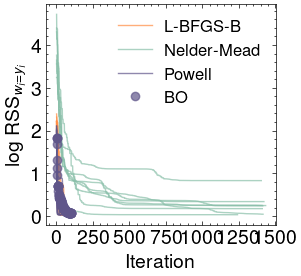

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Define colors for each method
# -------------------------------
colors = {'L-BFGS-B': '#FF8C42', 'Nelder-Mead': '#89BFA9', 'Powell': '#60568A'}

# -------------------------------
# Prepare figure
# -------------------------------
plt.figure(figsize=(3, 2.75), constrained_layout=True)

# -------------------------------
# Plot optimization paths
# -------------------------------
for method in ['L-BFGS-B', 'Nelder-Mead', 'Powell']:
    # Filter results for this method
    method_results = [res for res in results_spy if res['method'] == method]

    for idx, res_entry in enumerate(method_results):
        # Use intermediate function values if stored in res_entry['path'], otherwise just final value
        if 'path' in res_entry:
            path_values = np.array(res_entry['path'])
        else:
            path_values = np.array([res_entry['result'].fun])  # fallback to single value

        # Number of iterations
        iterations = np.arange(1, len(path_values) + 1)

        # Plot path
        plt.plot(
            iterations,
            np.log10(path_values),
            '-', 
            markersize=4,
            alpha=0.7,
            color=colors[method],
            label=method if idx == 0 else ""  # label only first run per method
        )

# -------------------------------
# Optional: overlay Bayesian Optimization iterations
# -------------------------------
objective_values = max_y_per_iteration  # From BO
iterations = np.arange(1, len(objective_values) + 1)
neg_objective_values = -np.array(objective_values)

plt.plot(
    iterations,
    neg_objective_values,
    "o",
    markersize=6, alpha=0.7,
    color='#60568A',
    label='BO'
)

# -------------------------------
# Customize plot
# -------------------------------
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$\\log$ RSS$_{w_{i}=y_{i}}$', fontsize=14)
#plt.xlim(-5, 100)
#plt.ylim(-1.5, 2.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=12, loc='upper right', ncols=1, columnspacing=0.1)

# -------------------------------
# Save and display
# -------------------------------
plt.savefig("optimization_paths_vs_iterations.pdf")
plt.show()


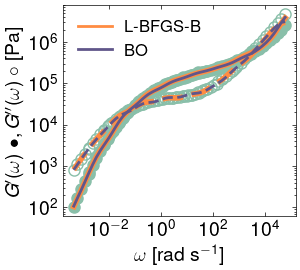

In [19]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

# Choose which method to plot
method_to_plot = 'L-BFGS-B'
method_color = '#FF8C42'  # color for this method
legend_lw = 2

# Create the plot
plt.figure(figsize=(3, 2.75))

# -------------------------------
# Plot experimental data
# -------------------------------
plt.plot(omega, G_prime, 'o', markersize=8, color='#89BFA9', label="G' (data)")
plt.plot(omega, G_double_prime, 'o', color='#89BFA9', fillstyle="none", markersize=8, label="G'' (data)")

# -------------------------------
# Plot best result for the selected method
# -------------------------------
method_results = [res for res in results_spy if res['method'] == method_to_plot]
if method_results:
    best_result = min(method_results, key=lambda r: r['result'].fun)
    best_params = best_result['result'].x
    N_modes = len(best_params)

    # Extract fitted G_i and use fixed tau
    G_best = 10 ** best_params
    tau_best = taus

    # Compute multi-mode Maxwell predictions
    Gp_model = np.zeros_like(omega)
    Gpp_model = np.zeros_like(omega)
    for i in range(N_modes):
        wt = omega * tau_best[i]
        Gp_model += G_best[i] * (wt**2) / (1 + wt**2)
        Gpp_model += G_best[i] * (wt) / (1 + wt**2)

    # Plot lines (thick)
    plt.plot(omega, Gp_model, '-', color=method_color, lw=4, label=f"{method_to_plot} fit G'")
    plt.plot(omega, Gpp_model, '--', color=method_color, lw=4, label=f"{method_to_plot} fit G''")

# -------------------------------
# Plot BO solution (optional)
# -------------------------------
plt.plot(omega, G_model_prime, '-', color='#60568A', lw=2, label="G' (BO fit)")
plt.plot(omega, G_model_double_prime, '--', color='#60568A', lw=2, label="G'' (BO fit)")

# -------------------------------
# Configure axes
# -------------------------------
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\omega$ [rad s$^{-1}$]', fontsize=14)
plt.ylabel(r'$G^{\prime}(\omega)~\bullet, G^{\prime \prime}(\omega)~\circ$ [Pa]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# -------------------------------
# Custom legend
# -------------------------------
handles = [
    mlines.Line2D([], [], color=method_color, lw=legend_lw, label=method_to_plot),
    mlines.Line2D([], [], color='#60568A', lw=legend_lw, label='BO'),
]
plt.legend(handles=handles, fontsize=12)

# -------------------------------
# Save and show
# -------------------------------
plt.savefig(f"fig_bo_fit_{method_to_plot}_comparison_multimode.pdf")
plt.show()


In [15]:
# Filter results for L-BFGS-B
lbfgsb_results = [res for res in results_spy if res['method'] == 'L-BFGS-B']

if lbfgsb_results:
    # Find the best result (lowest objective value)
    best_result = min(lbfgsb_results, key=lambda r: r['result'].fun)
    best_params = best_result['result'].x  # logG_i

    # Convert to G_i
    G_best = 10 ** best_params
    tau_best = taus
    eta_best = G_best * tau_best  # optional

    # Print fitted parameters
    print("Best parameters from L-BFGS-B:")
    for i, G_i in enumerate(G_best):
        print(f"Mode {i+1}: G = {G_i:.6f}, tau = {tau_best[i]:.6f}, eta = {eta_best[i]:.6f}")

    # Objective value
    print(f"Objective value: {best_result['result'].fun:.6f}")
else:
    print("No results found for L-BFGS-B")


Best parameters from L-BFGS-B:
Mode 1: G = 115.732982, tau = 2267.666870, eta = 262443.849586
Mode 2: G = 2730.721413, tau = 284.768366, eta = 777623.074759
Mode 3: G = 19985.760631, tau = 35.760553, eta = 714701.860770
Mode 4: G = 46651.597628, tau = 4.490728, eta = 209499.620398
Mode 5: G = 58337.287935, tau = 0.563935, eta = 32898.450424
Mode 6: G = 60606.808746, tau = 0.070818, eta = 4292.033589
Mode 7: G = 76560.292268, tau = 0.008893, eta = 680.859914
Mode 8: G = 237043.538702, tau = 0.001117, eta = 264.724900
Mode 9: G = 362274.140231, tau = 0.000140, eta = 50.806174
Mode 10: G = 5896003.574916, tau = 0.000018, eta = 103.836343
Objective value: 1.088220


In [16]:
# Filter results for L-BFGS-B
nm_results = [res for res in results_spy if res['method'] == 'Nelder-Mead']

if nm_results:
    # Find the best result (lowest objective value)
    best_result = min(nm_results, key=lambda r: r['result'].fun)
    best_params = best_result['result'].x  # logG_i

    # Convert to G_i
    G_best = 10 ** best_params
    tau_best = taus
    eta_best = G_best * tau_best  # optional

    # Print fitted parameters
    print("Best parameters from Nelder-Mead:")
    for i, G_i in enumerate(G_best):
        print(f"Mode {i+1}: G = {G_i:.6f}, tau = {tau_best[i]:.6f}, eta = {eta_best[i]:.6f}")

    # Objective value
    print(f"Objective value: {best_result['result'].fun:.6f}")
else:
    print("No results found for Nelder-Mead")


Best parameters from Nelder-Mead:
Mode 1: G = 115.732686, tau = 2267.666870, eta = 262443.178975
Mode 2: G = 2730.724138, tau = 284.768366, eta = 777623.850629
Mode 3: G = 19985.746217, tau = 35.760553, eta = 714701.345310
Mode 4: G = 46651.629028, tau = 4.490728, eta = 209499.761408
Mode 5: G = 58337.237625, tau = 0.563935, eta = 32898.422052
Mode 6: G = 60606.753030, tau = 0.070818, eta = 4292.029643
Mode 7: G = 76560.257779, tau = 0.008893, eta = 680.859608
Mode 8: G = 237043.882908, tau = 0.001117, eta = 264.725284
Mode 9: G = 362273.434164, tau = 0.000140, eta = 50.806075
Mode 10: G = 5896000.759229, tau = 0.000018, eta = 103.836294
Objective value: 1.088220


In [17]:
# Filter results for Powell
powell_results = [res for res in results_spy if res['method'] == 'Powell']

if powell_results:
    # Find the best result (lowest objective value)
    best_result = min(powell_results, key=lambda r: r['result'].fun)
    best_params = best_result['result'].x  # logG_i

    # Convert to G_i
    G_best = 10 ** best_params
    tau_best = taus
    eta_best = G_best * tau_best  # optional

    # Print fitted parameters
    print("Best parameters from Powell:")
    for i, G_i in enumerate(G_best):
        print(f"Mode {i+1}: G = {G_i:.6f}, tau = {tau_best[i]:.6f}, eta = {eta_best[i]:.6f}")

    # Objective value
    print(f"Objective value: {best_result['result'].fun:.6f}")
else:
    print("No results found for Powell")


Best parameters from Powell:
Mode 1: G = 115.733396, tau = 2267.666870, eta = 262444.787442
Mode 2: G = 2730.730275, tau = 284.768366, eta = 777625.598486
Mode 3: G = 19985.742813, tau = 35.760553, eta = 714701.223579
Mode 4: G = 46651.679447, tau = 4.490728, eta = 209499.987824
Mode 5: G = 58337.097891, tau = 0.563935, eta = 32898.343251
Mode 6: G = 60606.876960, tau = 0.070818, eta = 4292.038419
Mode 7: G = 76560.281748, tau = 0.008893, eta = 680.859821
Mode 8: G = 237043.799837, tau = 0.001117, eta = 264.725192
Mode 9: G = 362272.211997, tau = 0.000140, eta = 50.805904
Mode 10: G = 5896005.336796, tau = 0.000018, eta = 103.836374
Objective value: 1.088220


In [18]:
# -------------------------------
# Extract best BO parameters
# -------------------------------
# Find the index of the best BO result
best_bo_idx = np.argmax(best_y_samples)  # BO maximizes the acquisition function
best_bo_params = best_X_samples[best_bo_idx]

# Convert to physical units
G_bo_best = 10 ** best_bo_params
tau_bo_best = taus
eta_bo_best = G_bo_best * tau_bo_best  # viscosities

# Print results
print("Best parameters from Bayesian Optimization:")
for i in range(len(G_bo_best)):
    print(f"Mode {i+1}: G = {G_bo_best[i]:.6f}, tau = {tau_bo_best[i]:.6f}, eta = {eta_bo_best[i]:.6f}")

# Compute RSS to check fit quality
Gp_bo_model = np.zeros_like(omega)
Gpp_bo_model = np.zeros_like(omega)
for i in range(len(G_bo_best)):
    wt = omega * tau_bo_best[i]
    Gp_bo_model += G_bo_best[i] * (wt**2) / (1 + wt**2)
    Gpp_bo_model += G_bo_best[i] * (wt) / (1 + wt**2)

rss_bo = np.sum(((G_prime - Gp_bo_model) / G_prime)**2) + np.sum(((G_double_prime - Gpp_bo_model) / G_double_prime)**2)
print(f"Weighted RSS for BO fit: {rss_bo:.10f}")


Best parameters from Bayesian Optimization:
Mode 1: G = 121.985481, tau = 2267.666870, eta = 276622.433504
Mode 2: G = 2685.786959, tau = 284.768366, eta = 764827.163823
Mode 3: G = 20287.620311, tau = 35.760553, eta = 725496.529984
Mode 4: G = 43750.969243, tau = 4.490728, eta = 196473.688246
Mode 5: G = 58605.673428, tau = 0.563935, eta = 33049.802452
Mode 6: G = 65456.867734, tau = 0.070818, eta = 4635.503514
Mode 7: G = 74609.643100, tau = 0.008893, eta = 663.512556
Mode 8: G = 205285.406677, tau = 0.001117, eta = 229.258132
Mode 9: G = 425641.017670, tau = 0.000140, eta = 59.692894
Mode 10: G = 6100365.714618, tau = 0.000018, eta = 107.435428
Weighted RSS for BO fit: 1.1893457864
